In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResultsWrapper
from arch import arch_model
# Deactivate warnings
import warnings
warnings.filterwarnings('ignore')
# set figure size for all plots
plt.rcParams["figure.figsize"] = (15, 6)

# Partie 1. Analyse préliminaire (20 points)

## 1.a)
Chargez les données et ne gardez que les observations jusqu'à décembre 2019. Tracez la série brute $y_t$ avec des étiquettes sur chaque axe et un titre 'log(100 USDCAD=x)'. La dimension temporelle
doit apparaître sur l'axe des abscisses.

In [2]:
df = pd.read_csv("data_W2023.csv")
df.columns = ["date", "USDCAD"]

In [3]:
df = df[df["date"] < "2020-01-01"]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 0 to 563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    564 non-null    object 
 1   USDCAD  564 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.2+ KB


In [5]:
df["date"] = pd.to_datetime(df["date"])

In [6]:
df["log_100_USDCAD"] = np.log(100 * df["USDCAD"])

In [7]:
df.tail()

,date,USDCAD,log_100_USDCAD
559,2019-08-01,1.028977,4.633736
560,2019-09-01,1.023574,4.628470
561,2019-10-01,1.022401,4.627324
562,2019-11-01,1.024087,4.628971
563,2019-12-01,1.018995,4.623987


Text(0.5, 1.0, 'log 100 USDCAD=x')

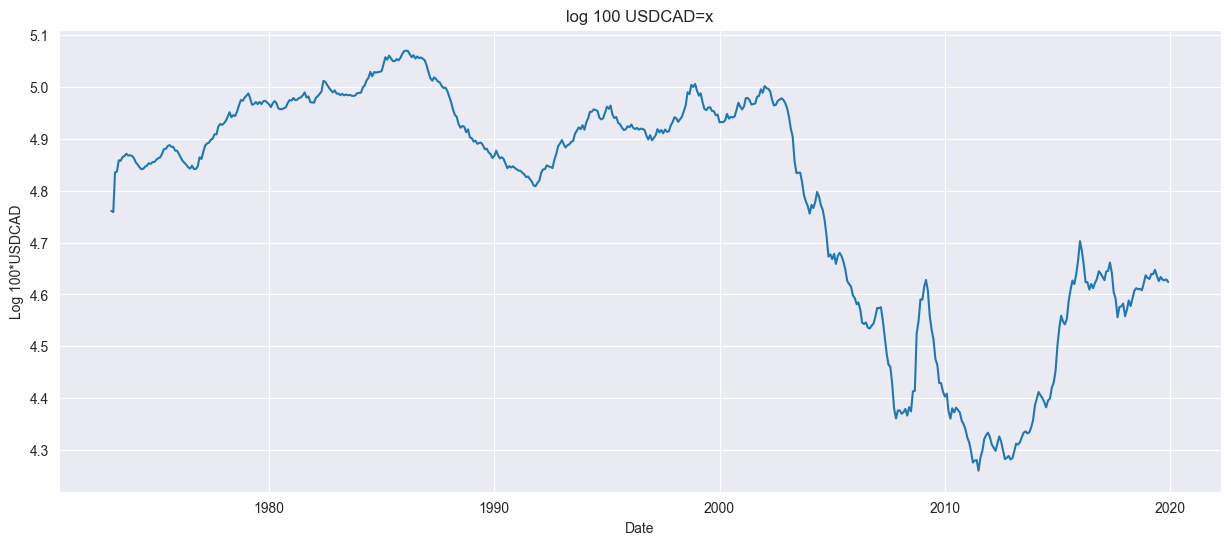

In [8]:
plt.plot(df["date"], df["log_100_USDCAD"])
plt.xlabel("Date")
plt.ylabel(f"Log 100*USDCAD")
plt.title("log 100 USDCAD=x")



## 1.b)
Supposons qu'il existe une tendance temporelle déterministe (polynôme d'ordre 2) : $\tau_t = \alpha + \beta t + \gamma t^2$
Appliquez la transformation requise pour stationnariser la série logarithmique (le logarithme du taux de change) et tracez la série résultante.

In [9]:
#1b
T = df.shape[0]
T

564

In [10]:
trend = np.arange(1, T + 1)
ones = np.ones(T)

In [11]:
X = np.column_stack((ones, trend, trend ** 2))
X

array([[1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00],
       [1.00000e+00, 3.00000e+00, 9.00000e+00],
       ...,
       [1.00000e+00, 5.62000e+02, 3.15844e+05],
       [1.00000e+00, 5.63000e+02, 3.16969e+05],
       [1.00000e+00, 5.64000e+02, 3.18096e+05]])

In [12]:
Y = df["log_100_USDCAD"].values

In [13]:
B = np.linalg.inv(X.T @ X) @ X.T @ Y

In [14]:
B

array([ 4.90909695e+00,  7.33070085e-04, -3.06987062e-06])

In [15]:
df["res"] = Y - X @ B

In [16]:
df

,date,USDCAD,log_100_USDCAD,res
0,1973-01-01,1.168677,4.761042,-0.148785
1,1973-02-01,1.166112,4.758845,-0.151705
2,1973-03-01,1.258816,4.835342,-0.075927
3,1973-04-01,1.260858,4.836962,-0.075018
4,1973-05-01,1.288661,4.858774,-0.053912
...,...,...,...,...
559,2019-08-01,1.028977,4.633736,0.276831
560,2019-09-01,1.023574,4.628470,0.274274
561,2019-10-01,1.022401,4.627324,0.275842
562,2019-11-01,1.024087,4.628971,0.280210


Text(0.5, 1.0, 'Determinist trend deviation')

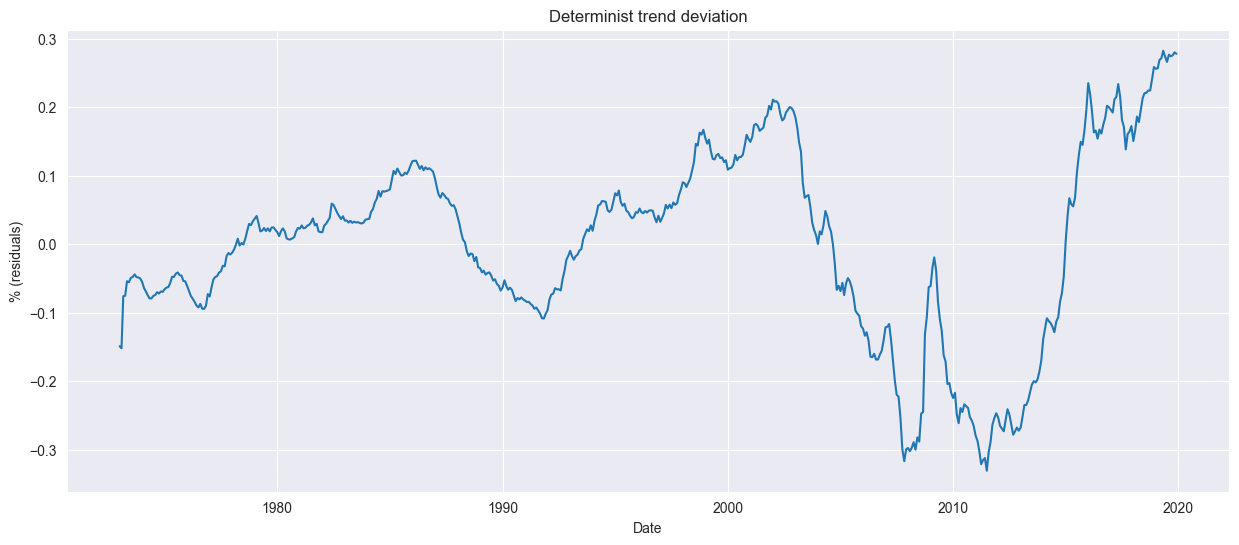

In [17]:
plt.plot(df["date"], df["res"])
plt.xlabel("Date")
plt.ylabel(f"% (residuals)")
plt.title("Determinist trend deviation")

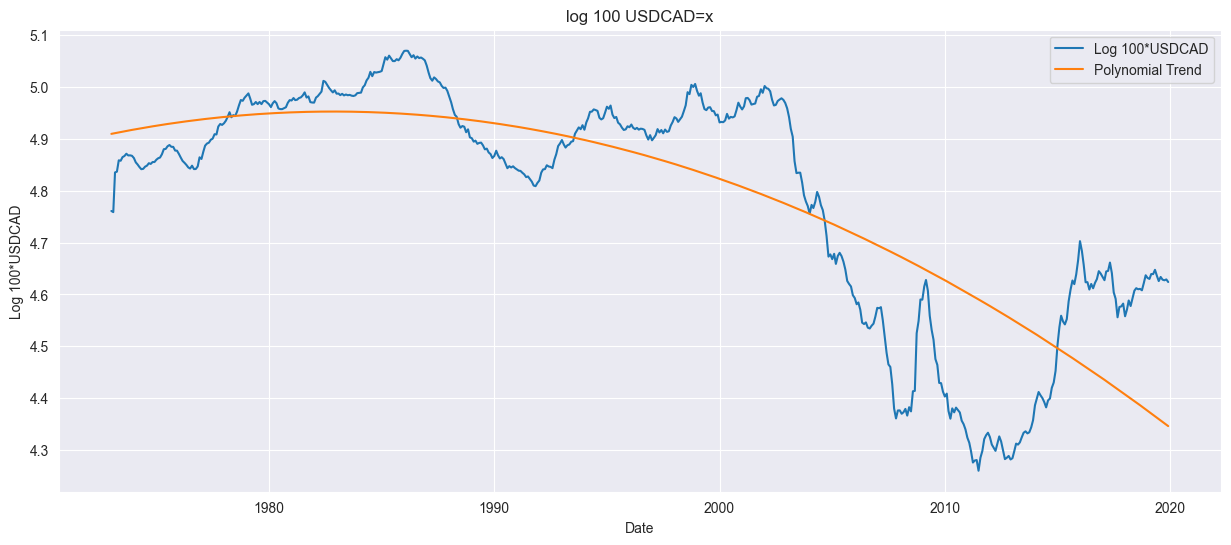

In [18]:
plt.plot(df["date"], df["log_100_USDCAD"], label="Log 100*USDCAD")
plt.plot(df["date"], X @ B, label="Polynomial Trend")
plt.xlabel("Date")
plt.ylabel(f"Log 100*USDCAD")
plt.title("log 100 USDCAD=x")
plt.legend()


## 1.c)
Supposons qu'il existe une tendance temporelle stochastique, c'est-à-dire une marche aléatoire. Appliquez la transformation requise pour stationnariser la série logarithmique (le logarithme du taux de change) et tracez la série résultante.

In [19]:
#1c
df["stoch_USDCAD"] = df["log_100_USDCAD"].diff() * 100
df.dropna(inplace=True) # drop first row
df.shape


(563, 5)

In [20]:
df.head()

,date,USDCAD,log_100_USDCAD,res,stoch_USDCAD
1,1973-02-01,1.166112,4.758845,-0.151705,-0.219688
2,1973-03-01,1.258816,4.835342,-0.075927,7.649618
3,1973-04-01,1.260858,4.836962,-0.075018,0.162085
4,1973-05-01,1.288661,4.858774,-0.053912,2.181160
5,1973-06-01,1.287592,4.857944,-0.055441,-0.083011


Text(0.5, 1.0, 'Hypothesis: stochastic trend')

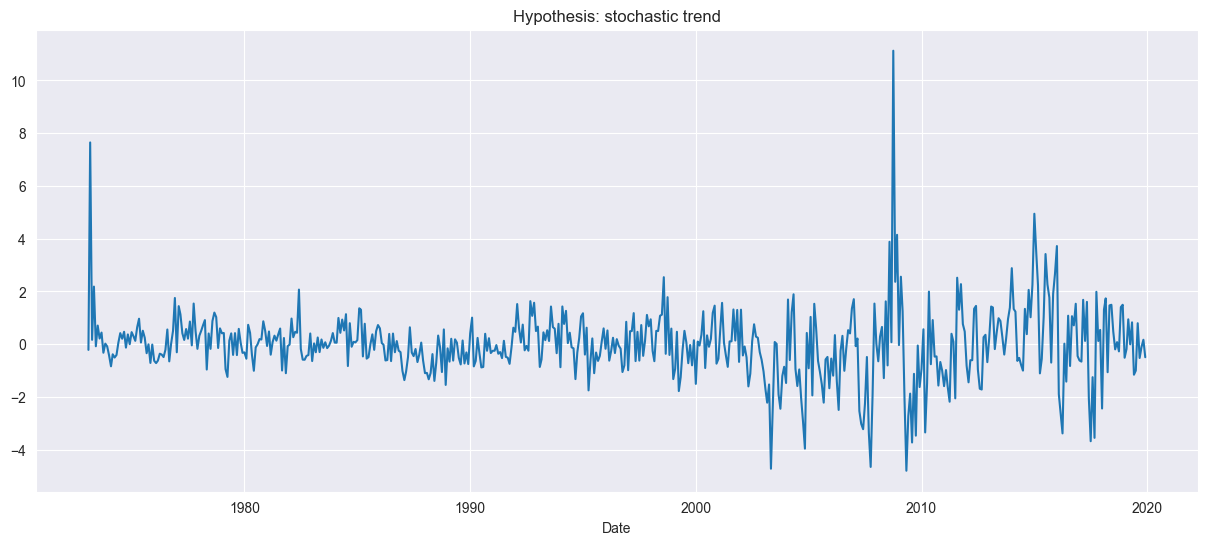

In [21]:
plt.plot(df["date"], df["stoch_USDCAD"])
plt.xlabel("Date")
plt.title("Hypothesis: stochastic trend")

## 1.d)
Analysez les fonctions d'autocorrélation de l'échantillon pour évaluer si les séries sont stationnaires. Quelle série choisiriez-vous pour estimer un modèle de série chronologique ?

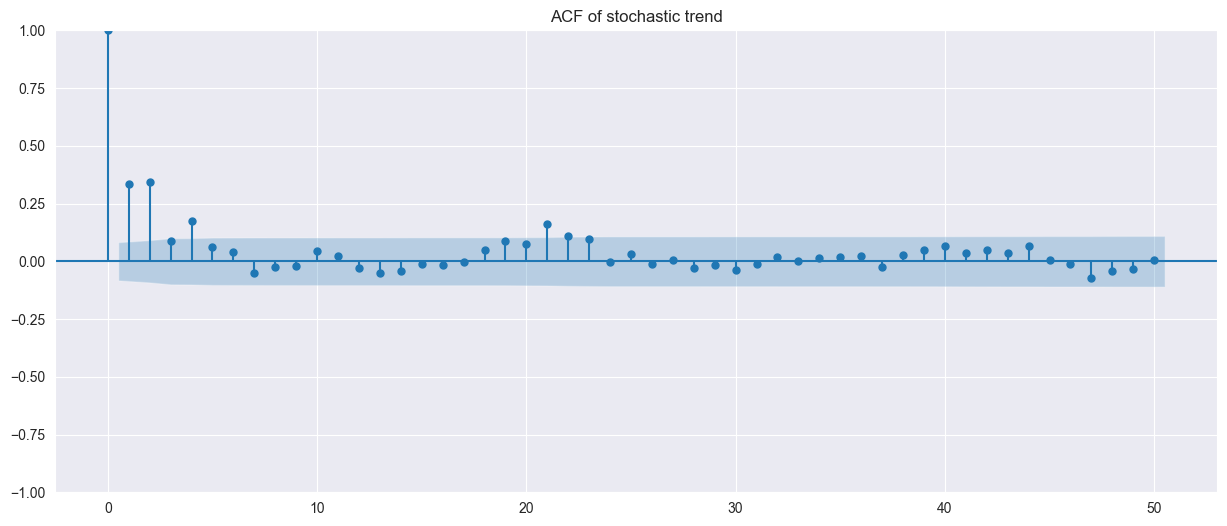

In [22]:
# 1d
sm.graphics.tsa.plot_acf(df["stoch_USDCAD"], lags=50, title="ACF of stochastic trend");


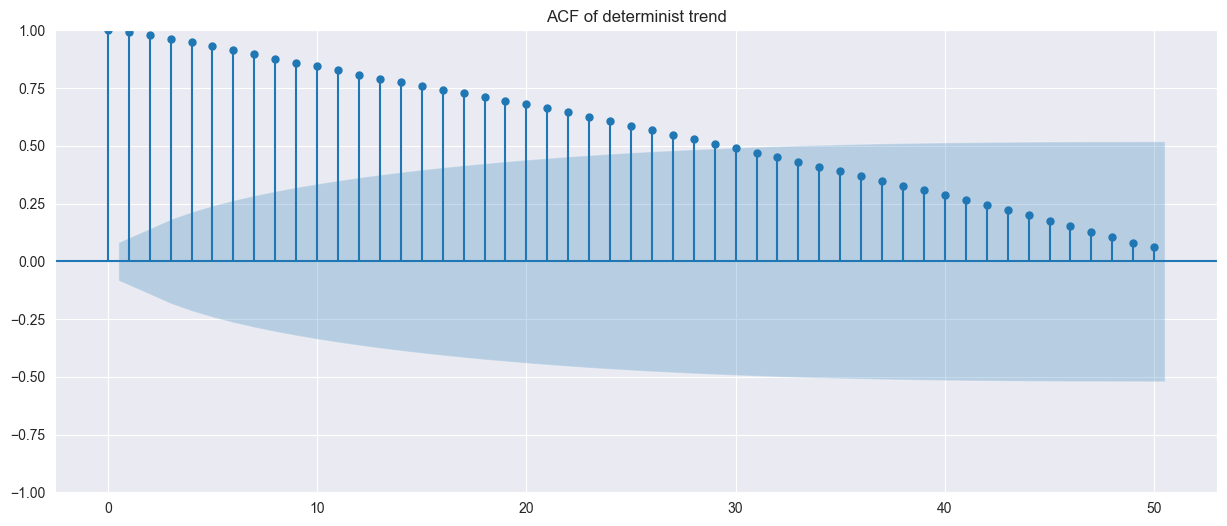

In [23]:
sm.graphics.tsa.plot_acf(df["res"], lags=50, title="ACF of determinist trend");

Pour commencer, on sait que l'autocorrélation non conditionnelle est une mesure de la dépendance temporelle, ce qui nous permet à partir des graphiques d'autocorrélations, de conclure sur la nature stationnaire de la série. On attend d'une série stationnaire des mouvements autour d'une moyenne et de bornes qui sont fixes dans le temps.


- Concernant le graphique des autocorrélations de la tendance déterministe polynomiale, on observe que les autocorrélations tendent lentement vers 0. La moyenne des autocorrélations n'est donc pas nulle. On peut donc conclure que la série `log_100_USDCAD` n'est pas stationnaire.
- D'autre part, on observe que les autocorrélations de la série à tendance stochastique tendent rapidement vers 0 pour les 50 lags testés, avec une moyenne qui à l'air nulle en fonction du nombre de lags.

On sait que tout processus stationnaire est caractérisé par une courte mémoire: $Corr(y_t, y_{t-i}) \rightarrow 0$ lorsque $i$ augmente. On peut donc conclure que la série `stoch_USDCAD` est stationnaire.


## 1.e)
A partir de maintenant, utilisez exclusivement la série qui est stationnaire. Effectuez les tests de Ljung-Box avec 1 à 18 lags pour vérifier si la série est un bruit blanc et concluez.

In [24]:
#1e

ljung_box_test = sm.stats.acorr_ljungbox(df["stoch_USDCAD"], lags=18)
ljung_box_test


,lb_stat,lb_pvalue
1,63.837877,1.350911e-15
2,130.932915,3.700656e-29
3,135.330291,3.838951e-29
4,153.014709,4.598552e-32
5,155.108804,1.090679e-31
6,156.108470,3.947901e-31
7,157.514338,1.069480e-30
8,157.903502,4.387614e-30
9,158.157909,1.792324e-29
10,159.368871,4.373649e-29


In [25]:
# verify that the column lb_pvalue have all is p-values inferior to the 5% threshold
all(ljung_box_test["lb_pvalue"] < 0.05)

True

On rappelle que le test de Ljung-Box permet de tester l'hypothèse nulle d'absence d'autocorrélation pour les termes bruits blancs : $H_0: Corr(y_t, y_{t-i}) = 0,  \forall i \in \mathbb{N^+}$.

On remarque que les `lb_pvalues` (p-values pour le test de Ljung-Box) sont très faibles pour les lags 1 à 18. On peut donc rejeter l'hypothèse nulle d'absence de corrélation pour ces lags au seuil de 5%. On peut donc conclure que les résidus ne sont pas indépendants et que la série est autocorrélée, ce qui implique que le terme d'erreur de la série `stoch_USDCAD` n'est pas bruit blanc.

# Partie 2. Choix du modèle (30 points)

Considérons les 8 modèles suivants :
- AR(1): $y_t = \delta + \phi_1 y_{t-1} + \epsilon_t$
- AR(2): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t$
- AR(3): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \epsilon_t$
- AR(4): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \phi_4 y_{t-4} + \epsilon_t$
- ARMA(1,1): $y_t = \delta + \phi_1 y_{t-1} - \theta_1 \epsilon_{t-1} + \epsilon_t$
- ARMA(2,2): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} + \epsilon_t$
- ARMA(3,3): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \theta_3 \epsilon_{t-3} + \epsilon_t$
- ARMA(4,4): $y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \phi_4 y_{t-4} - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \theta_3 \epsilon_{t-3} - \theta_4 \epsilon_{t-4} + \epsilon_t$

## 2.a)
Estimez les 8 modèles par maximum de vraisemblance, présentez les résultats de l'estimation et vérifiez si les conditions de stationnarité sont satisfaites.

In [26]:
def compute_eigenvalues(arma_model: ARIMAResultsWrapper) -> np.ndarray:
    """Compute the eigenvalues of the ARMA model."""

    arparams = arma_model.arparams # store the AR parameters
    if len(arparams) == 1: # if there is only one AR parameter (True for AR(1) model)
        eigmat = np.array([[arparams[0]]])
    elif len(arparams) == 2:
        eigmat = np.array([[arparams[0], arparams[1]],
                           [1, 0]])
    elif len(arparams) == 3:
        eigmat = np.array([[arparams[0], arparams[1], arparams[2]],
                           [1, 0, 0],
                           [0, 1, 0]])
    elif len(arparams) == 4:
        eigmat = np.array([[arparams[0], arparams[1], arparams[2], arparams[3]],
                           [1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, 0]])
    else:
        raise ValueError("The number of AR parameters must be between 1 and 4")

    return np.linalg.eigvals(eigmat) # compute the eigenvalues of the matrix

In [27]:
def check_stationarity(eigenvalues: np.ndarray) -> bool:
    """Check if the eigenvalues of the ARMA model are inferior to 1."""
    if eigenvalues.dtype == np.complex128: # If eigenvalues are complex, calcul the norm
        a = np.real(eigenvalues)
        b = np.imag(eigenvalues)
        return all(np.sqrt(a**2 + b**2) < 1)
    else: # If eigenvalues are real, check if they are inferior to 1 in absolute value
        return all(np.abs(eigenvalues) < 1)

In [28]:
order_list = [([1], 0, [0]),
               ([1, 2], 0, [0]),
               ([1, 2, 3], 0, [0]),
               ([1, 2, 3, 4], 0, [0]),
               ([1], 0, [1]),
               ([1, 2], 0, [1, 2]),
               ([1, 2, 3], 0, [1, 2, 3]),
               ([1, 2, 3, 4], 0, [1, 2, 3, 4])]


In [29]:
arma_models = {}

for order in order_list:
    print(f"Autoregressive lags: {order[0]}")
    print(f"Moving average lags: {order[2]}")

    model = ARIMA(df["stoch_USDCAD"], order=order)
    results = model.fit()
    print(results.summary())
    arma_models[f"ARMA({order[0][-1]},{order[2][-1]})"] = results


Autoregressive lags: [1]
Moving average lags: [0]
                               SARIMAX Results                                
Dep. Variable:           stoch_USDCAD   No. Observations:                  563
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -919.472
Date:                Mon, 27 Feb 2023   AIC                           1844.945
Time:                        11:01:12   BIC                           1857.945
Sample:                             0   HQIC                          1850.020
                                - 563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0249      0.086     -0.291      0.771      -0.193       0.143
ar.L1          0.3353      0.031     10.804      0.000       0.274       0.396
si

In [30]:
compute_eigenvalues(arma_models["ARMA(1,1)"])

array([0.72848943])

In [31]:
arma_models["ARMA(1,1)"].arparams

array([0.72848943])

In [32]:
df_stationarity = pd.DataFrame(index=arma_models.keys(), columns=["is_stationary"])
for model_name, model in arma_models.items():
    eigenvalues = compute_eigenvalues(model)
    df_stationarity.loc[model_name, "is_stationary"] = check_stationarity(eigenvalues)
df_stationarity

,is_stationary
"ARMA(1,0)",True
"ARMA(2,0)",True
"ARMA(3,0)",True
"ARMA(4,0)",True
"ARMA(1,1)",True
"ARMA(2,2)",True
"ARMA(3,3)",True
"ARMA(4,4)",True


2.b) Effectuez des tests de rapport de vraisemblance pour justifier la sélection de deux modèles. Sélectionnez d'abord le meilleur parmi AR(1), AR(2), AR(3) et AR(4). Sélectionnez ensuite le meilleur modèle parmi ARMA(1,1), ARMA(2,2), ARMA(3,3) et ARMA(4,4). Utilisez le BIC pour justifier la sélection du meilleur de ces deux modèles.

In [33]:
def compute_lr_statistic(reduced_ll: float, full_ll: float) -> float:
    """Compute the likelihood ratio statistic."""
    return -2 * (reduced_ll - full_ll)

In [34]:
def compute_p_value_llr(reduced_ll: float, full_ll: float, df: int = 1) -> float:
    """Compute the p-value of the likelihood ratio test."""
    lr_statistic = compute_lr_statistic(reduced_ll=reduced_ll, full_ll=full_ll)
    p_val = sp.stats.chi2.sf(lr_statistic, df=df)
    return p_val

On commence par sélectionner le meilleur modèle parmi AR(1), AR(2), AR(3) et AR(4).

- H0: Le modèle complet ARMA(2,0) fit les données aussi bien que le modèle réduit ARMA(1,0). Par conséquent, on devrait choisir le modèle ARMA(1,0) car il est plus simple.
- H1: Le modèle complet ARMA(2,0) fit mieux les données que le modèle réduit ARMA(1,0). Par conséquent, on devrait choisir le modèle ARMA(2,0) car il est plus précis.

In [35]:
compute_p_value_llr(arma_models["ARMA(1,0)"].llf,
                    arma_models["ARMA(2,0)"].llf,
                    df=1)

7.820378576433156e-11

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(2,0) fit mieux les données que le modèle ARMA(1,0).

- H0: Le modèle complet ARMA(3,0) fit les données aussi bien que le modèle réduit ARMA(2,0). Par conséquent, on devrait choisir le modèle ARMA(2,0) car il est plus simple.
- H1: Le modèle complet ARMA(3,0) fit mieux les données que le modèle réduit ARMA(2,0). Par conséquent, on devrait choisir le modèle ARMA(3,0) car il est plus précis.

In [36]:
compute_p_value_llr(arma_models["ARMA(2,0)"].llf,
                    arma_models["ARMA(3,0)"].llf,
                    df=1)

0.007646861433308557

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(3,0) fit mieux les données que le modèle ARMA(2,0).

- H0: Le modèle complet ARMA(4,0) fit les données aussi bien que le modèle réduit ARMA(3,0). Par conséquent, on devrait choisir le modèle ARMA(3,0) car il est plus simple.
- H1: Le modèle complet ARMA(4,0) fit mieux les données que le modèle réduit ARMA(3,0). Par conséquent, on devrait choisir le modèle ARMA(4,0) car il est plus précis.

In [37]:
compute_p_value_llr(arma_models["ARMA(3,0)"].llf,
                    arma_models["ARMA(4,0)"].llf,
                    df=1)

0.006280983257624901

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(4,0) fit mieux les données que le modèle ARMA(3,0).

**On peut donc conclure que d'après le test du ratio de vraisemblance, le modèle AR(4) est le meilleur modèle pour modéliser les données parmis les modèles AR.**

On utilise le même raisonnement mis avec maintenant des modèles ARMA(p, q) pour sélectionner le meilleur modèle parmi ARMA(1,1), ARMA(2,2), ARMA(3,3) et ARMA(4,4).

- H0: Le modèle complet ARMA(2,2) fit les données aussi bien que le modèle réduit ARMA(1,1). Par conséquent, on devrait choisir le modèle ARMA(1,1) car il est plus simple.
- H1: Le modèle complet ARMA(2,2) fit mieux les données que le modèle réduit ARMA(1,1). Par conséquent, on devrait choisir le modèle ARMA(2,2) car il est plus précis.

In [38]:
compute_p_value_llr(arma_models["ARMA(1,1)"].llf,
                    arma_models["ARMA(2,2)"].llf,
                    df=2)

5.093383915441103e-07

Comme la p-value est inférieur au seuil significatif de 5%, on rejette l'hypothèse nulle et on peut donc conclure que le modèle ARMA(2,2) fit mieux les données que le modèle ARMA(1,1).

- H0: Le modèle complet ARMA(3,3) fit les données aussi bien que le modèle réduit ARMA(2,2). Par conséquent, on devrait choisir le modèle ARMA(2,2) car il est plus simple.
- H1: Le modèle complet ARMA(3,3) fit mieux les données que le modèle réduit ARMA(2,2). Par conséquent, on devrait choisir le modèle ARMA(3,3) car il est plus précis.

In [39]:
compute_p_value_llr(arma_models["ARMA(2,2)"].llf,
                    arma_models["ARMA(3,3)"].llf,
                    df=2)

0.3676921427657294

Comme la p-value est supérieur au seuil significatif de 5%, on ne peut pas rejeter l'hypothèse nulle et on peut donc conclure que le modèle ARMA(2,2) fit aussi bien les données que le modèle ARMA(3,3). Par conséquent, on devrait choisir le modèle ARMA(2,2) car il est plus simple.

In [40]:
compute_p_value_llr(arma_models["ARMA(2,2)"].llf,
                    arma_models["ARMA(4,4)"].llf,
                    df=4)

0.3448921452955723

**On peut donc conclure que d'après le test du ratio de vraisemblance, le modèle ARMA(2,2) est le meilleur modèle pour modéliser les données parmis les modèles ARMA.**

In [41]:
# BIC test between AR(4) and ARMA(2,2)
arma_models["ARMA(2,2)"].bic, arma_models["ARMA(4,0)"].bic

(1822.7987872439364, 1820.0598903433222)

In [42]:
df_bic = pd.DataFrame({"BIC": [arma_models["ARMA(2,2)"].bic, arma_models["ARMA(4,0)"].bic]},
                      index=["ARMA(2,2)", "AR(4)"])
df_bic

,BIC
"ARMA(2,2)",1822.798787
AR(4),1820.059890


On remarque que le BIC du modèle AR(4) est plus petit que celui du modèle ARMA(2,2). Par conséquent, et d'après le critère d'information de Bayes, le modèle AR(4) est le meilleur modèle pour modéliser les données.

In [43]:
#2c evaluate the white noise hypothesis for each of the two models.
resid_arma_2_2 = arma_models["ARMA(2,2)"].resid
resid_arma_4_0 = arma_models["ARMA(4,0)"].resid
resid_arma_1_0 = arma_models["ARMA(1,0)"].resid


In [44]:
sm.stats.acorr_ljungbox(resid_arma_2_2, lags=18, return_df=True)

,lb_stat,lb_pvalue
1,0.019365,0.889326
2,0.687187,0.709217
3,0.707994,0.871322
4,1.595710,0.809563
5,4.884819,0.430098
6,5.217740,0.516205
7,6.400846,0.493800
8,7.974911,0.435925
9,8.162355,0.517871
10,10.680986,0.382906


In [45]:
# check that all lb_pvalues are > 0.05
all(sm.stats.acorr_ljungbox(resid_arma_2_2, lags=18, return_df=True).lb_pvalue > 0.05)

True

Après avoir effectué le test de Ljung-Box sur le modèle ARMA(2,2), on remarque que la p-value est supérieur au seuil significatif de 5% pour tous les 18 lags. Par conséquent, on ne peut pas rejeter l'hypothèse nulle que le terme d'erreur possède des autocorrélations de 0. Par conséquent, on peut conclure que le terme d'erreur du modèle ARMA(2,2) est un bruit blanc.

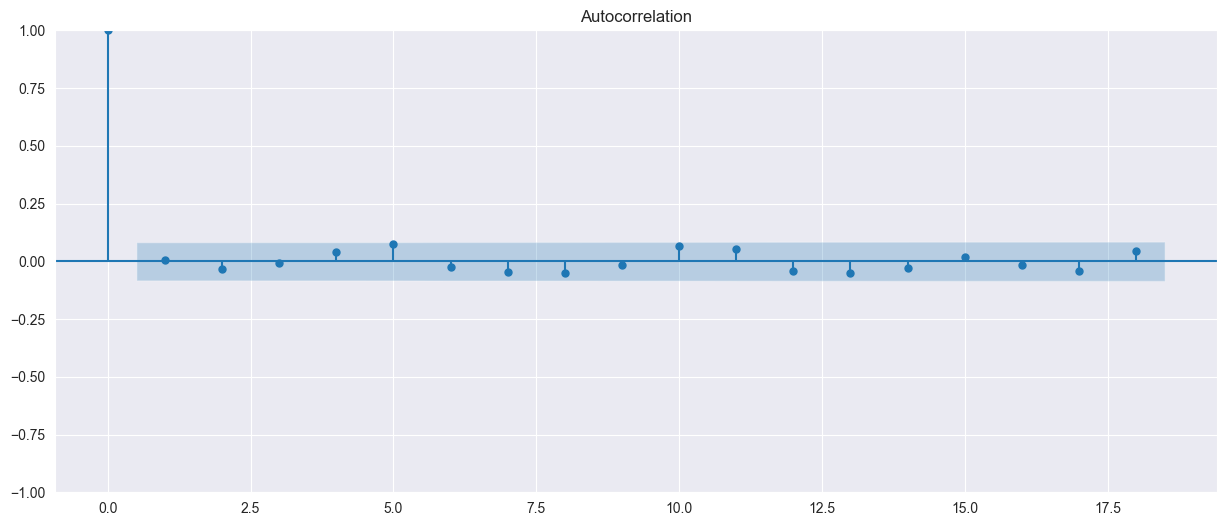

In [46]:
# autocorrelation plot to confirm our results
fig, ax = plt.subplots(figsize=(15, 6))
fig = sm.graphics.tsa.plot_acf(resid_arma_2_2, lags=18, ax=ax)


In [47]:
sm.stats.acorr_ljungbox(resid_arma_4_0, lags=18, return_df=True)

,lb_stat,lb_pvalue
1,0.022608,0.880481
2,0.160005,0.923114
3,0.284247,0.962964
4,0.286832,0.990648
5,0.827707,0.975233
6,1.626631,0.950644
7,3.507857,0.834393
8,4.859857,0.772444
9,5.277459,0.809482
10,7.568857,0.670869


In [48]:
# check that all lb_pvalues are > 0.05
all(sm.stats.acorr_ljungbox(resid_arma_4_0, lags=18, return_df=True).lb_pvalue > 0.05)

True

Après avoir effectué le test de Ljung-Box sur le modèle AR(4), on remarque que la p-value est supérieur au seuil significatif de 5% pour tous les 18 lags. Par conséquent, on ne peut pas rejeter l'hypothèse nulle que le terme d'erreur possède des autocorrélations de 0. Par conséquent, on peut conclure que le terme d'erreur du modèle AR(4) est un bruit blanc.

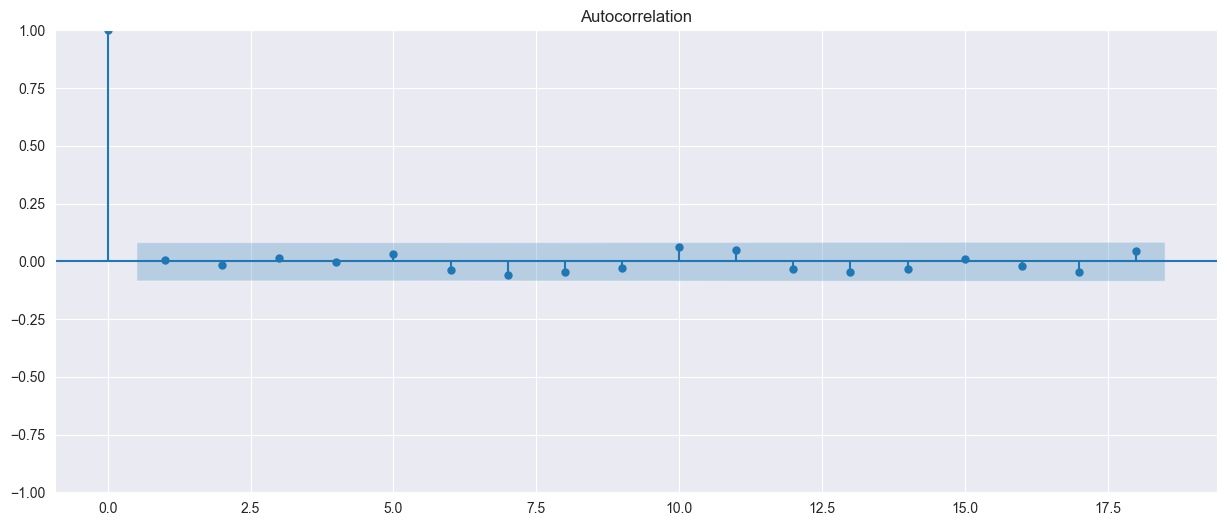

In [49]:
# autocorrelation plot
fig, ax = plt.subplots(figsize=(15, 6))
fig = sm.graphics.tsa.plot_acf(resid_arma_4_0, lags=18, ax=ax)

In [50]:
sm.stats.acorr_ljungbox(resid_arma_1_0, lags=18, return_df=True)

,lb_stat,lb_pvalue
1,4.261575,3.898377e-02
2,45.933833,1.060706e-10
3,50.167877,7.357811e-11
4,65.664649,1.863951e-13
5,65.689926,8.060455e-13
6,67.027592,1.661358e-12
7,69.662315,1.728765e-12
8,69.683916,5.680488e-12
9,70.341134,1.305289e-11
10,72.165245,1.690236e-11


In [51]:
# check that all lb_pvalues are < 0.05
all(sm.stats.acorr_ljungbox(resid_arma_1_0, lags=18, return_df=True).lb_pvalue < 0.05)

True

Après avoir effectué le test de Ljung-Box sur le modèle AR(1), on remarque que la p-value est inférieur au seuil significatif de 5% pour tous les 18 lags. Par conséquent, on peut rejeter l'hypothèse nulle que le terme d'erreur possède des autocorrélations de 0. Par conséquent, on peut conclure que le terme d'erreur du modèle AR(1) n'est pas un bruit blanc.

# Réponse dynamique et prédiction

3.a) Pour les deux modèles sélectionnés, évaluez la réponse dynamique pour un horizon de 10 périodes suite à un choc positif de taille $\sigma = 1.15$ survenant à la première période de l'horizon. Tracez les deux fonctions de réponse impulsionnelle sur la même figure et commentez.

In [52]:
sigma = 1.15

In [53]:
impulse_res_arma22 = arma_models["ARMA(2,2)"].impulse_responses(steps=10, impulse=[sigma])

In [54]:
impulse_res_arma40 = arma_models["ARMA(4,0)"].impulse_responses(steps=10, impulse=[sigma])

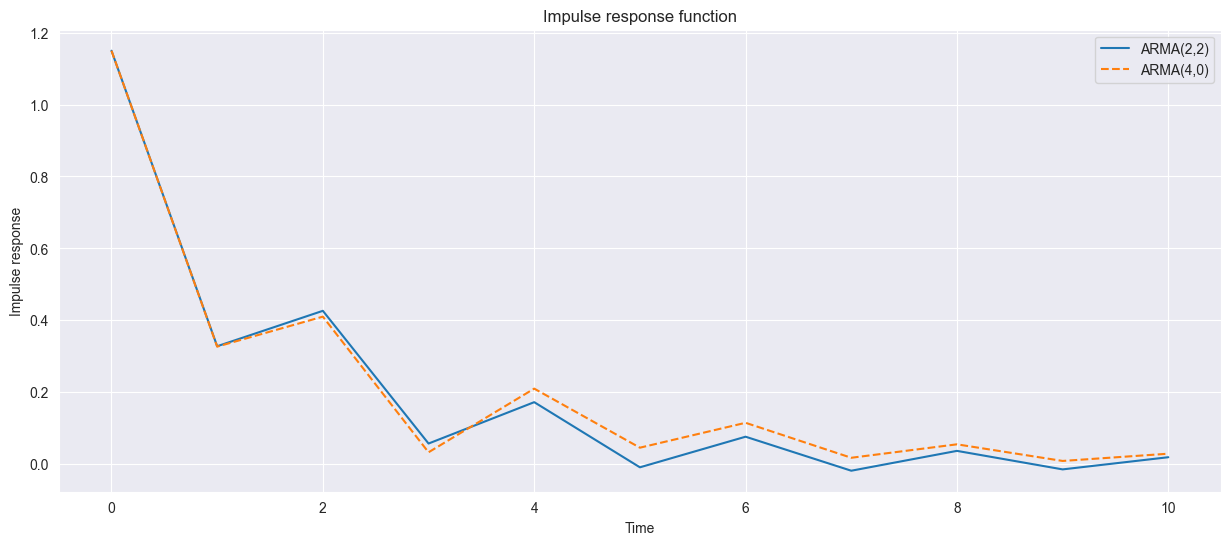

In [55]:
plt.plot(impulse_res_arma22, label="ARMA(2,2)")
plt.plot(impulse_res_arma40, label="ARMA(4,0)", linestyle="--")
plt.legend()
plt.title("Impulse response function")
plt.xlabel("Time")
plt.ylabel("Impulse response")
plt.show()

3.b) Un choc négatif de taille $\sigma = 1.15$ se produit pendant 3 périodes consécutives de l'horizon (t, t+1, t+2). Tracez les deux fonctions de réponse impulsionnelle pour les deux modèles sélectionnés,
montrant la réponse dynamique pour un horizon de 20 périodes après ces chocs, et expliquez ce qui se passe.

In [56]:
steps = 20

In [57]:
def compute_three_impulse(arma_model, sigma, steps):
    first_impulse = arma_model.impulse_responses(steps=steps, impulse=[-sigma])
    second_impulse = first_impulse
    second_impulse = pd.concat([pd.Series([0]), second_impulse], ignore_index=True)
    second_impulse = second_impulse[0:-1]
    third_impulse = first_impulse
    third_impulse = pd.concat([pd.Series([0, 0]), third_impulse], ignore_index=True)
    third_impulse = third_impulse[0:-2]
    total_impulse = first_impulse + second_impulse + third_impulse
    return total_impulse

In [58]:
arma22_total_impulse = compute_three_impulse(arma_models["ARMA(2,2)"], sigma, steps)
arma40_total_impulse = compute_three_impulse(arma_models["ARMA(4,0)"], sigma, steps)
arma22_total_impulse

0    -1.150000
1    -1.477488
2    -1.903556
3    -0.810223
4    -0.654546
5    -0.218952
6    -0.237949
7    -0.047132
8    -0.092901
9    -0.001931
10   -0.039517
11    0.006959
12   -0.018343
13    0.006604
14   -0.009179
15    0.004645
16   -0.004858
17    0.002953
18   -0.002668
19    0.001794
20   -0.001499
dtype: float64

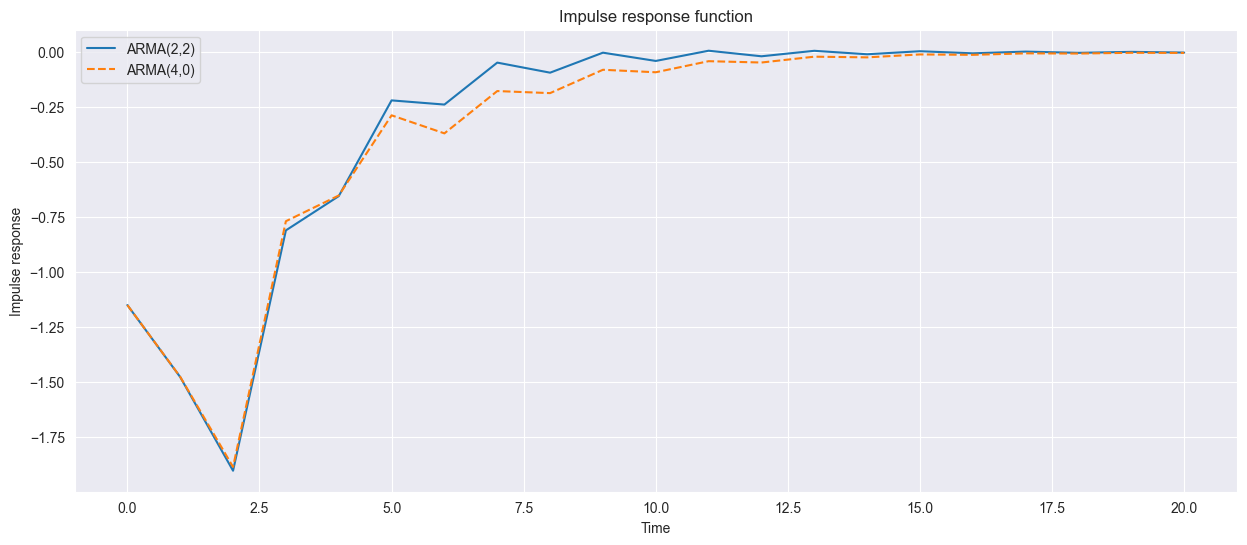

In [59]:
plt.plot(arma22_total_impulse, label="ARMA(2,2)")
plt.plot(arma40_total_impulse, label="ARMA(4,0)", linestyle="--")
plt.legend()
plt.title("Impulse response function")
plt.xlabel("Time")
plt.ylabel("Impulse response")
plt.show()

3.c) Prévision : Divisez l'échantillon en un échantillon d'entraînement (training sample) et un échantillon de validation (holdout sample). L'échantillon de validation devrait être composé des 34 dernières observations.

• Ré-estimez les deux modèles sélectionnés en utilisant uniquement l'échantillon d'entraînement.
• Pour chacun des deux modèles, calculez les prévisions à un pas en avant : $\mathbb{E}_t(USDCAD_{t+1})$ pour les
modèles AR(4) et ARMA(4,4). Ces prévisions conditionnelles ne sont pas les mêmes !
• Tracez ces prévisions avec la série réelle (différence première) sur le même graphique pour la période
couverte par l'échantillon de validation.
• Tracez la série réelle (données brutes en niveaux) contre les prévisions à un pas d'avance et la prévision
naïve : $\mathbb{E}_t(USDCAD_{t+1}) = USDCAD_t$.



In [60]:
treshold = 34

train_sample = df["stoch_USDCAD"].iloc[:-treshold]
val_sample = df["stoch_USDCAD"].iloc[-treshold:]

In [61]:
len(train_sample), len(val_sample)

(529, 34)

In [62]:
train_sample.tail(), val_sample.head(), val_sample.tail()

(525    0.711067
 526    1.530210
 527   -0.453625
 528   -0.622313
 529   -0.663968
 Name: stoch_USDCAD, dtype: float64,
 530    1.679185
 531    0.120254
 532    1.601213
 533   -2.062462
 534   -3.684382
 Name: stoch_USDCAD, dtype: float64,
 559    0.791843
 560   -0.526515
 561   -0.114658
 562    0.164758
 563   -0.498462
 Name: stoch_USDCAD, dtype: float64)

In [63]:
order_list = [([1, 2, 3, 4], 0, [0]),
               ([1, 2], 0, [1, 2]),
               ([1, 2, 3, 4], 0, [1, 2, 3, 4])]

In [64]:
arma_models2 = {}

for order in order_list:
    print(f"Autoregressive lags: {order[0]}")
    print(f"Moving average lags: {order[2]}")

    model = ARIMA(train_sample, order=order)
    results = model.fit()
    print(results.summary())
    arma_models2[f"ARMA({order[0][-1]},{order[2][-1]})"] = results

Autoregressive lags: [1, 2, 3, 4]
Moving average lags: [0]
                               SARIMAX Results                                
Dep. Variable:           stoch_USDCAD   No. Observations:                  529
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -826.065
Date:                Mon, 27 Feb 2023   AIC                           1664.130
Time:                        11:01:18   BIC                           1689.756
Sample:                             0   HQIC                          1674.161
                                - 529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0176      0.122     -0.144      0.886      -0.257       0.222
ar.L1          0.3024      0.036      8.376      0.000       0.232      

In [65]:
# Compute predictions for one periode ahead
forecast_arma40 = arma_models2["ARMA(4,0)"].forecast(steps=treshold).reset_index(drop=True)
forecast_arma40

0    -0.108468
1    -0.186622
2    -0.063807
3    -0.150797
4    -0.054195
5    -0.081854
6    -0.030805
7    -0.051625
8    -0.025480
9    -0.036109
10   -0.021352
11   -0.027255
12   -0.019444
13   -0.022756
14   -0.018509
15   -0.020319
16   -0.018023
17   -0.019027
18   -0.017787
19   -0.018341
20   -0.017669
21   -0.017975
22   -0.017612
23   -0.017780
24   -0.017584
25   -0.017676
26   -0.017570
27   -0.017621
28   -0.017563
29   -0.017591
30   -0.017560
31   -0.017576
32   -0.017559
33   -0.017567
Name: predicted_mean, dtype: float64

In [66]:
forecast_arma44 = arma_models2["ARMA(4,4)"].forecast(steps=treshold).reset_index(drop=True)

In [67]:
val_sample.reset_index(drop=True)

0     1.679185
1     0.120254
2     1.601213
3    -2.062462
4    -3.684382
5    -1.254936
6    -3.556535
7     1.984063
8     0.118671
9     0.537326
10   -2.443875
11    1.309600
12    1.733595
13   -1.066896
14    1.466750
15    1.491800
16    0.480067
17   -0.201468
18    0.074795
19   -0.276336
20    1.403459
21    1.492025
22   -0.517171
23   -0.185861
24    0.939289
25   -0.009112
26    0.825015
27   -1.162107
28   -1.005409
29    0.791843
30   -0.526515
31   -0.114658
32    0.164758
33   -0.498462
Name: stoch_USDCAD, dtype: float64

In [68]:
forecast_naive = np.zeros(treshold)
forecast_naive[0] = train_sample.iloc[-1]

In [69]:
forecast_naive[1:] = val_sample.iloc[:-1]
len(forecast_naive)

34

In [70]:
# change index to date for plotting
forecast_arma40.index = df["date"].iloc[-treshold:]
forecast_arma44.index = df["date"].iloc[-treshold:]
val_sample.index = df["date"].iloc[-treshold:]
forecast_naive = pd.Series(forecast_naive, index=df["date"].iloc[-treshold:])
forecast_arma40

date
2017-03-01   -0.108468
2017-04-01   -0.186622
2017-05-01   -0.063807
2017-06-01   -0.150797
2017-07-01   -0.054195
2017-08-01   -0.081854
2017-09-01   -0.030805
2017-10-01   -0.051625
2017-11-01   -0.025480
2017-12-01   -0.036109
2018-01-01   -0.021352
2018-02-01   -0.027255
2018-03-01   -0.019444
2018-04-01   -0.022756
2018-05-01   -0.018509
2018-06-01   -0.020319
2018-07-01   -0.018023
2018-08-01   -0.019027
2018-09-01   -0.017787
2018-10-01   -0.018341
2018-11-01   -0.017669
2018-12-01   -0.017975
2019-01-01   -0.017612
2019-02-01   -0.017780
2019-03-01   -0.017584
2019-04-01   -0.017676
2019-05-01   -0.017570
2019-06-01   -0.017621
2019-07-01   -0.017563
2019-08-01   -0.017591
2019-09-01   -0.017560
2019-10-01   -0.017576
2019-11-01   -0.017559
2019-12-01   -0.017567
Name: predicted_mean, dtype: float64

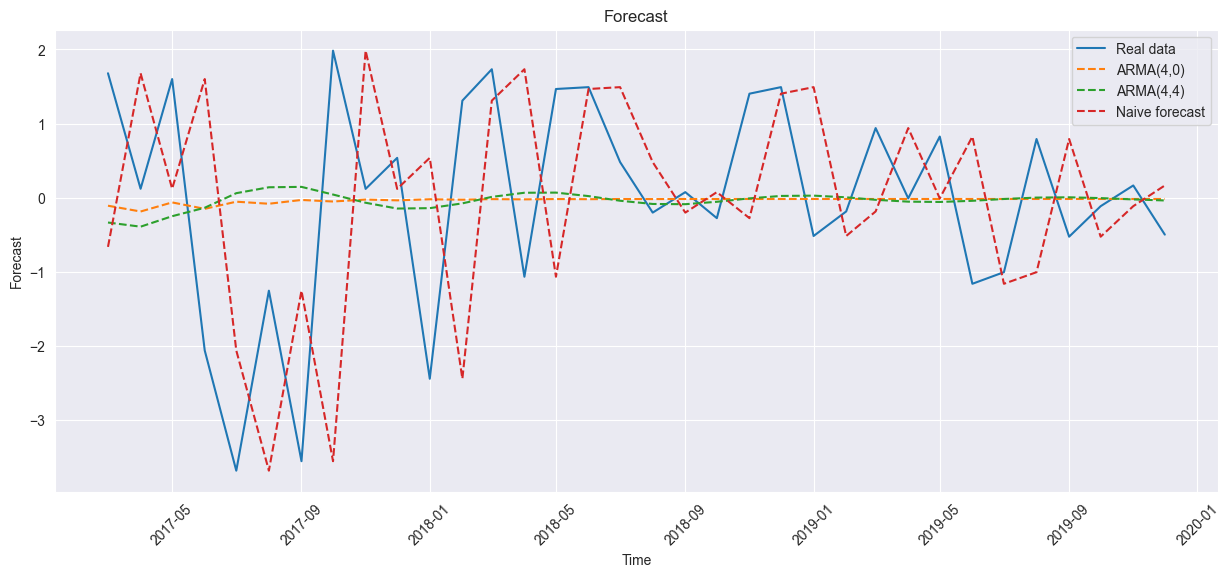

In [71]:
plt.plot(val_sample, label="Real data")
plt.plot(forecast_arma40, label="ARMA(4,0)", linestyle="--")
plt.plot(forecast_arma44, label="ARMA(4,4)", linestyle="--")
plt.plot(forecast_naive, label="Naive forecast", linestyle="--")
plt.legend()
plt.title("Forecast")
plt.xlabel("Time")
# rotate xticks by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Forecast")
plt.show()

3.d) Indiquez l'erreur quadratique moyenne pour chaque modèle en utilisant uniquement l'échantillon de 34 observations pour évaluer la performance de la prévision. Comparez ces statistiques à l'estimateur naïf suivant : $\mathbb{E}_t(y_{t+1}) = y_t$pour h=1 seulement. Quel modèle devrions-nous utiliser dans chaque cas ?


In [72]:
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [73]:
mse_arma40 = compute_mse(val_sample, forecast_arma40)
mse_arma44 = compute_mse(val_sample, forecast_arma44)
mse_naive = compute_mse(val_sample, forecast_naive)

In [74]:
mse_df = pd.DataFrame({"ARMA(4,0)": mse_arma40,
                       "ARMA(4,4)": mse_arma44,
                       "Naive forecast": mse_naive},
                      index=["MSE"])
mse_df

,"ARMA(4,0)","ARMA(4,4)",Naive forecast
MSE,1.986487,2.08732,3.832131


# Partie 4. Améliorations supplémentaires par la modélisation de la variance conditionnelle (30 points)

4.a) Tracez les fonctions d'autocorrélation et d'autocorrélation partielle de $y_t^2$. Que pouvez-vous conclure ?

In [75]:
df["stoch_USDCAD**2"] = df["stoch_USDCAD"] ** 2

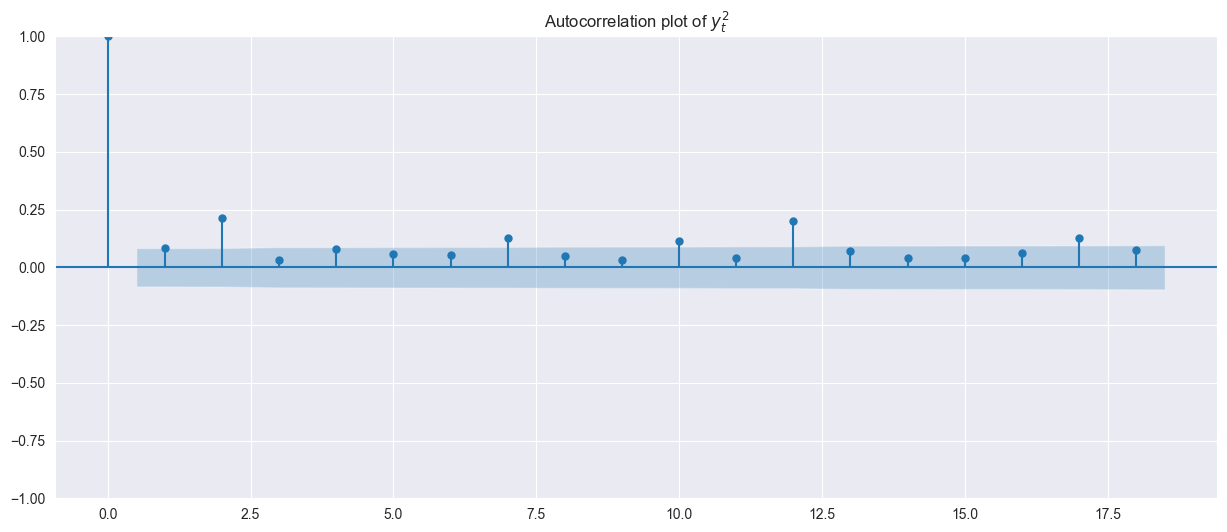

In [76]:
#plot autocorrelation
sm.graphics.tsa.plot_acf(df["stoch_USDCAD**2"], lags=18, title=f"Autocorrelation plot of $y_t^2$");

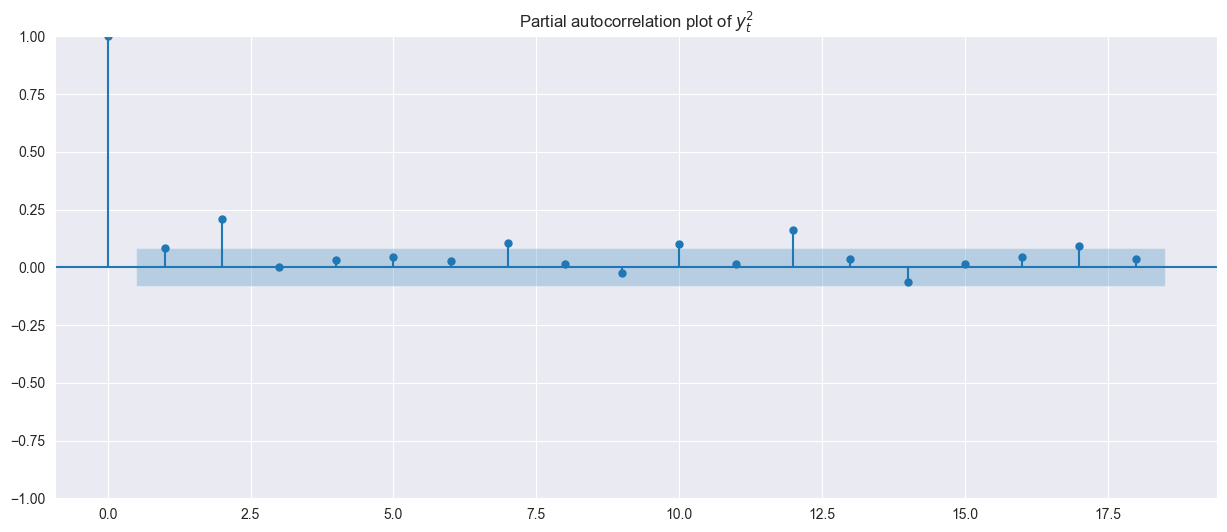

In [77]:
# plot partial autocorrelation
sm.graphics.tsa.plot_pacf(df["stoch_USDCAD**2"], lags=18, title=f"Partial autocorrelation plot of $y_t^2$");

4.b) Estimez les versions ARCH(1) et GARCH(1,1) des deux modèles sélectionnés par maximum de vraisemblance en utilisant seulement l'échantillon d'entraînement, et rapportez les estimations.


In [78]:
# estimate ARCH(1) model
arch1 = arch_model(train_sample, p=1, q=0, vol="ARCH")
arch1_results = arch1.fit()
arch1_results.summary()


Iteration:      1,   Func. Count:      5,   Neg. LLF: 2328.162769796222
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1000.7682896954569
Iteration:      3,   Func. Count:     18,   Neg. LLF: 919.2967441172533
Iteration:      4,   Func. Count:     24,   Neg. LLF: 869.2566611400279
Iteration:      5,   Func. Count:     28,   Neg. LLF: 869.2566574134169
Iteration:      6,   Func. Count:     31,   Neg. LLF: 869.2566574134241
Optimization terminated successfully    (Exit mode 0)
            Current function value: 869.2566574134169
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           stoch_USDCAD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -869.257
Distribution:                  Normal   AIC:                           1744.51
Method:            Maximum Likelihood   BIC:                           1757.33
                                        No. Observations:                  529
Date:                Mon, Feb 27 2023   Df Residuals:                      528
Time:                        11:01:23   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0340  5.237e-02      0.650      0.516 [-6.863e-02,  0.137]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.2142      0.403      3.010  2.613e-03   [  0.424,  2.005]
alpha[1]       0.3454      0.142      2.437  1.482e-02 [6.757e-02,  0.623]
==========================================================================

Covariance estimator: robust
"""

In [79]:
garch11 = arch_model(train_sample, p=1, q=1, vol="GARCH")
garch11_results = garch11.fit()
garch11_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2104.851698310853
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2338.286881122544
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1319.5773121505258
Iteration:      4,   Func. Count:     29,   Neg. LLF: 759.8392461902946
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1118.0796911667676
Iteration:      6,   Func. Count:     41,   Neg. LLF: 759.7952137572474
Iteration:      7,   Func. Count:     46,   Neg. LLF: 759.7931457626787
Iteration:      8,   Func. Count:     51,   Neg. LLF: 759.7931018704885
Iteration:      9,   Func. Count:     55,   Neg. LLF: 759.7931018534857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 759.7931018704885
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           stoch_USDCAD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -759.793
Distribution:                  Normal   AIC:                           1527.59
Method:            Maximum Likelihood   BIC:                           1544.67
                                        No. Observations:                  529
Date:                Mon, Feb 27 2023   Df Residuals:                      528
Time:                        11:01:23   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0187  4.645e-02     -0.403      0.687 [ -0.110,7.234e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0517  2.241e-02      2.308  2.100e-02 [7.798e-03,9.564e-02]
alpha[1]       0.3180      0.101      3.144  1.667e-03     [  0.120,  0.516]
beta[1]        0.6820  6.878e-02      9.915  3.568e-23     [  0.547,  0.817]
============================================================================

Covariance estimator: robust
"""

4.c) Effectuez des tests de rapport de vraisemblance pour sélectionner un modèle entre AR(4), AR(4) ARCH(1), et AR(4) GARCH(1,1). Répétez cette procédure pour sélectionner un modèle entre ARMA(4,4), ARMA(4,4) ARCH(1), et ARMA(4,4) GARCH(1,1).


In [80]:
def compute_arima_garch_models(train_sample: pd.Series,
                               p_arima: int,
                               q_arima: int,
                               p_garch: int,
                               q_garch: int,
                               vol: str = "GARCH"):
    """Compute ARIMA and GARCH models."""
    # Estimate ARIMA model
    arima = ARIMA(train_sample, order=(p_arima, 0, q_arima))
    arima_results = arima.fit()
    arima_resid = arima_results.resid

    # Estimate GARCH model
    garch = arch_model(arima_resid, p=p_garch, q=q_garch, vol=vol)
    garch_results = garch.fit(disp="off")

    return arima_results, garch_results


In [81]:
# Estimate a AR(4)ARCH(1) model
ar4, ar4arch1 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=0, p_garch=1, q_garch=1, vol="ARCH")
ar4arch1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -820.306
Distribution:                  Normal   AIC:                           1646.61
Method:            Maximum Likelihood   BIC:                           1659.42
                                        No. Observations:                  529
Date:                Mon, Feb 27 2023   Df Residuals:                      528
Time:                        11:01:23   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0315  4.987e-02      0.632      0.527 [-6.623e-02,  0.129]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.1086      0.306      3.624  2.896e-04    [  0.509,  1.708]
alpha[1]       0.2122      0.123      1.719  8.553e-02 [-2.968e-02,  0.454]
===========================================================================

Covariance estimator: robust
"""

In [82]:
# Estimate a AR(4)GARCH(1,1) model
ar4, ar4garch11 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=0, p_garch=1, q_garch=1, vol="GARCH")
# Estimate a ARMA(4,4)GARCH(1,1) model
arma44, arma44garch11 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=4, p_garch=1, q_garch=1, vol="GARCH")
# Estimate a ARMA(4,4)ARCH(1) model
arma44, arma44arch1 = compute_arima_garch_models(train_sample, p_arima=4, q_arima=4, p_garch=1, q_garch=0, vol="ARCH")

- H0: Le modèle complet AR(4)-ARCH(1) fit les données aussi bien que le modèle réduit AR(4). Par conséquent, on devrait choisir le modèle AR(4) car il est plus simple.
- H1: Le modèle complet AR(4)-ARCH(1) fit mieux les données que le modèle réduit AR(4). Par conséquent, on devrait choisir le modèle AR(4)-ARCH(1) car il est plus précis.

In [83]:
compute_p_value_llr(ar4.llf,
                    ar4arch1.loglikelihood,
                    df=2)

0.003153465650231915

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle AR(4)-ARCH(1).

- H0: Le modèle complet AR(4)-GARCH(1,1) fit les données aussi bien que le modèle réduit AR(4)-ARCH(1). Par conséquent, on devrait choisir le modèle ARMA(4,4) car il est plus simple.
- H1: Le modèle complet AR(4)-GARCH(1,1) fit mieux les données que le modèle réduit AR(4)-ARCH(1). Par conséquent, on devrait choisir le modèle AR(4)-GARCH(1,1) car il est plus précis.

In [84]:
compute_p_value_llr(ar4arch1.loglikelihood,
                    ar4garch11.loglikelihood,
                    df=1)

1.5560401364778586e-43

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle AR(4)-GARCH(1,1).

- H0: Le modèle complet ARMA(4,4)-ARCH(1) fit les données aussi bien que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4) car il est plus simple.
- H1: Le modèle complet ARMA(4,4)-ARCH(1) fit mieux les données que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4)-ARCH(1) car il est plus précis.

In [85]:
compute_p_value_llr(arma44.llf,
                    arma44arch1.loglikelihood,
                    df=2)

0.3785304053686332

Comme la p-value est inférieure à 0.05, on ne peut pas rejeter l'hypothèse nulle et on choisit le modèle ARMA(4,4).

- H0: Le modèle complet ARMA(4,4)-GARCH(1,1) fit les données aussi bien que le modèle réduit ARMA(4,4)-ARCH(1). Par conséquent, on devrait choisir le modèle ARMA(4,4)-ARCH(1) car il est plus simple.
- H1: Le modèle complet ARMA(4,4)-GARCH(1,1) fit mieux les données que le modèle réduit ARMA(4,4)-ARCH(1). Par conséquent, on devrait choisir le modèle ARMA(4,4)-GARCH(1,1) car il est plus précis.

In [86]:
compute_p_value_llr(arma44arch1.loglikelihood,
                    arma44garch11.loglikelihood,
                    df=1)

1.1244867248871488e-39

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle ARMA(4,4)-GARCH(1,1).

- H0: Le modèle complet ARMA(4,4)-GARCH(1,1) fit les données aussi bien que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4) car il est plus simple.
- H1: Le modèle complet ARMA(4,4)-GARCH(1,1) fit mieux les données que le modèle réduit ARMA(4,4). Par conséquent, on devrait choisir le modèle ARMA(4,4)-GARCH(1,1) car il est plus précis.

In [87]:
compute_p_value_llr(arma44.llf,
                    arma44garch11.loglikelihood,
                    df=3)

7.521450543484376e-38

Comme la p-value est inférieure à 0.05, on rejette l'hypothèse nulle et on choisit le modèle ARMA(4,4)-GARCH(1,1).

**On devrait donc choisir le modèle ARMA(4,4)-GARCH(1,1) et AR(4)-GARCH(1,1) d'après le critère du ratio de vraisemblance.**

4.d) Effectuez un test de spécification sur les résidus pour AR(4) ARCH(1) et AR(4) GARCH(1,1). Quel est le meilleur modèle pour la variance conditionnelle ?

In [88]:
def compute_specification_test(resid_square: pd.Series, h_t: pd.Series) -> pd.Series:
    """
    Compute the specification test for the conditional variance
    :param resid_square: the squared residuals
    :param h_t: the conditional variance
    :return: the specification test
    """
    return resid_square / h_t

In [89]:
ar4arch1_resid_sq = ar4arch1.resid.reset_index(drop=True) ** 2
ar4garch11_resid_sq = ar4garch11.resid.reset_index(drop=True) ** 2

In [90]:
#get ar4arch1 parameters
alpha_0 = ar4arch1.params.iloc[1]
alpha_1 = ar4arch1.params.iloc[2]



In [91]:
# Compute variance of AR(4) ARCH(1) model
arch4arch1_h = np.zeros(len(ar4arch1_resid_sq))
# initial guess for conditionnal variance
arch4arch1_h[0] = alpha_0 / (1 - alpha_1)

In [92]:
for i in range(1, len(ar4arch1_resid_sq)):
    arch4arch1_h[i] = alpha_0 + alpha_1 * ar4arch1_resid_sq[i-1]

In [93]:
# get ar4garch11 parameters
alpha_0 = ar4garch11.params.iloc[1]
alpha_1 = ar4garch11.params.iloc[2]
beta_1 = ar4garch11.params.iloc[3]

In [94]:
# Compute variance of AR(4) GARCH(1,1) model
arch4garch11_h = np.zeros(len(ar4garch11_resid_sq))
# initial guess
arch4garch11_h[0] = alpha_0 / (1 - alpha_1 - beta_1)

In [95]:
for i in range(1, len(ar4garch11_resid_sq)):
    arch4garch11_h[i] = alpha_0 + alpha_1 * ar4garch11_resid_sq[i-1] + beta_1 * arch4garch11_h[i-1]

In [96]:
# Compute specification test
ar4arch1_spec_test = compute_specification_test(ar4arch1_resid_sq, arch4arch1_h)
ar4garch11_spec_test = compute_specification_test(ar4garch11_resid_sq, arch4garch11_h)


In [97]:
# Use ljung box test on the specification test
ar4arch1_ljung_box = sm.stats.acorr_ljungbox(ar4arch1_spec_test, lags=18)
ar4arch1_ljung_box


,lb_stat,lb_pvalue
1,0.065457,0.798069
2,2.704905,0.258605
3,2.723726,0.436210
4,2.879816,0.578135
5,3.110696,0.682924
6,7.111503,0.310659
7,7.689661,0.360753
8,7.731775,0.460100
9,7.736728,0.560880
10,14.642019,0.145668


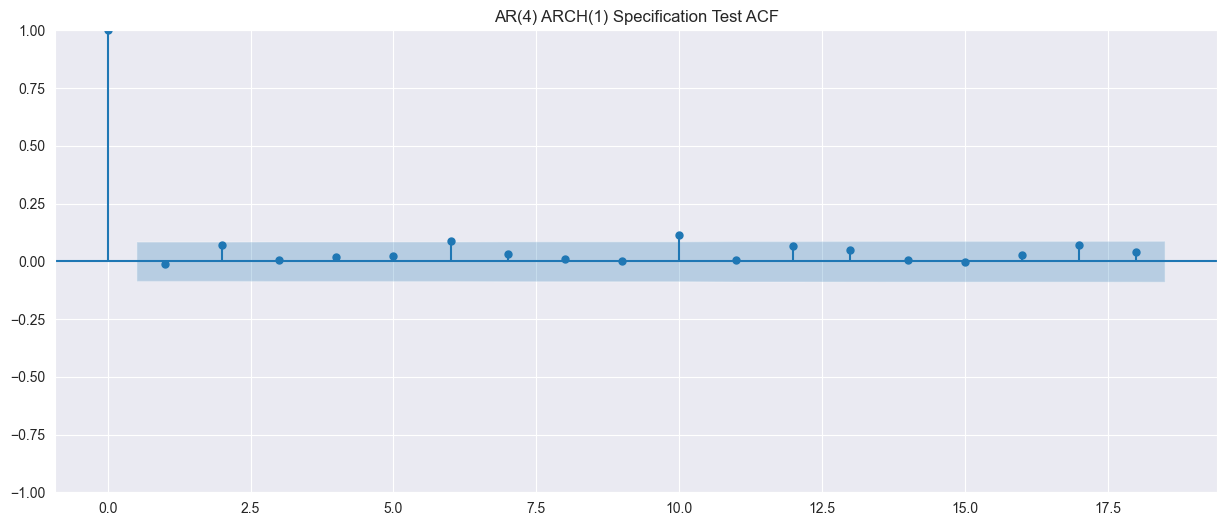

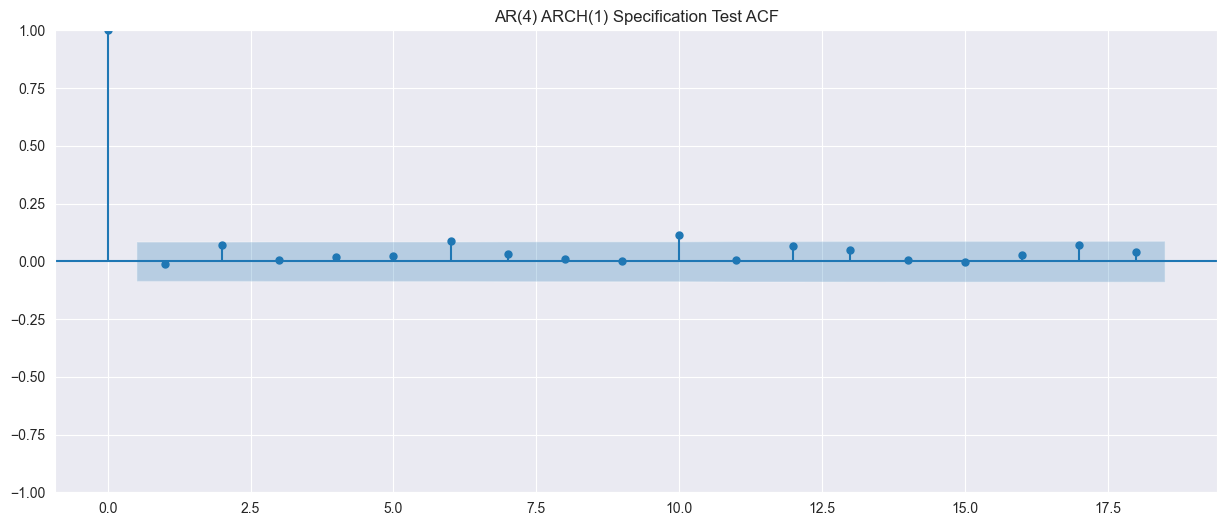

In [98]:
# plot the acf of the specification test
sm.graphics.tsa.plot_acf(ar4arch1_spec_test, lags=18, title="AR(4) ARCH(1) Specification Test ACF")


In [99]:
ar4garch11_ljung_box = sm.stats.acorr_ljungbox(ar4garch11_spec_test, lags=18)
ar4garch11_ljung_box

,lb_stat,lb_pvalue
1,1.540613,0.214527
2,2.225624,0.328633
3,3.388078,0.335571
4,3.791518,0.434955
5,3.794509,0.579365
6,3.985053,0.678699
7,3.986422,0.781340
8,6.101311,0.635885
9,6.364120,0.702995
10,6.370918,0.783197


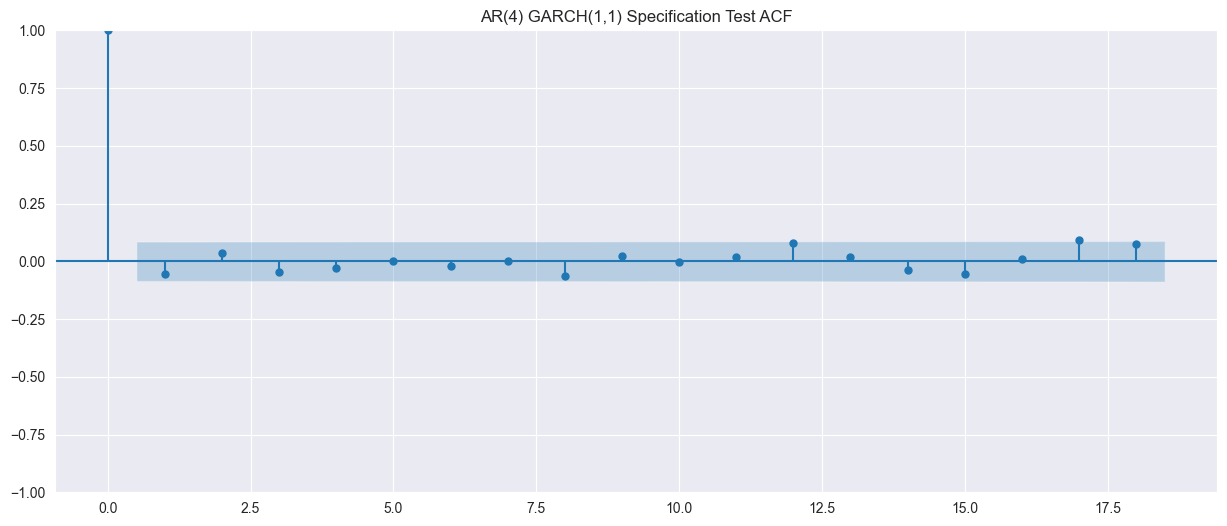

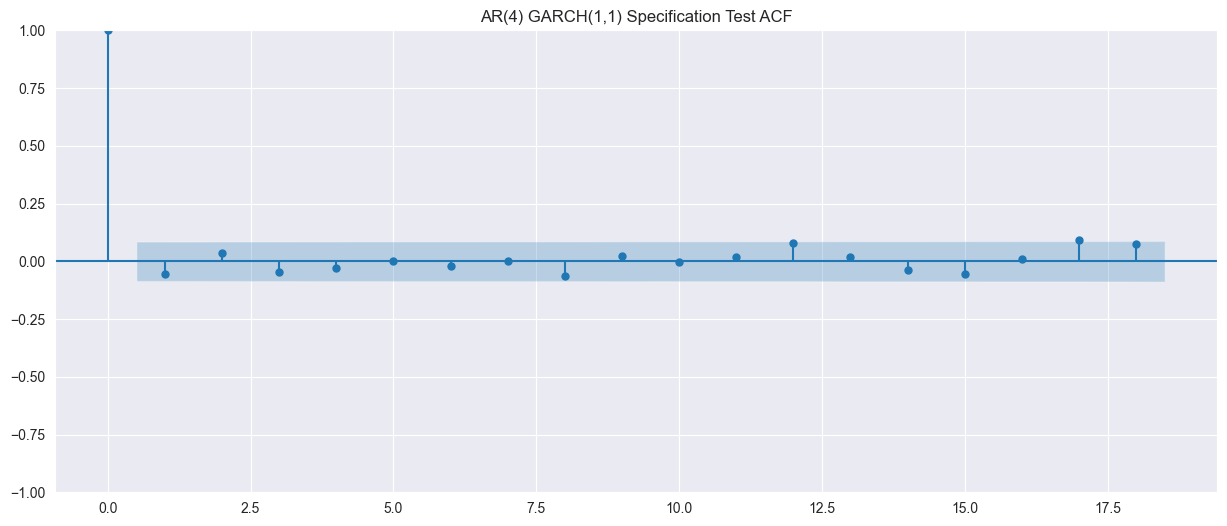

In [100]:
sm.graphics.tsa.plot_acf(ar4garch11_spec_test, lags=18, title="AR(4) GARCH(1,1) Specification Test ACF")

4.e) Pour ces deux nouveaux modèles et les deux modèles étudiés dans la partie 3, tracez les fonctions de réponse impulsionnelle du second cas décrit dans la partie 3. Dans quelle mesure sont-elles différentes ?


4.f) Comme dans la partie 3, tracez les prévisions à un pas d'avance $\mathbb{E}_t(y_{t+1})$ pour la période couverte par l'échantillon de validation (holdout sample). Comparez-les avec celles obtenues dans la partie 3.

4.g) Comparez les erreurs quadratiques moyennes de la prévision à un pas (pour la série transformée !) pour les deux modèles sélectionnés dans la partie 3, les deux nouveaux modèles, la prévision naïve $\mathbb{E}_t(y_{t+1}) = y_t$
et la prévision paresseuse $\mathbb{E}_t(y_{t+1}) = 0$ pour tous les t. Cette dernière suppose que la série en
niveaux ne changera pas. Que pouvez-vous conclure ? La modélisation de la covariance conditionnelle était-elle utile ?